# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical,plot_model
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score,ShuffleSplit,train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from skimage import io
from PIL import Image
import scipy.sparse as sparse
import pandas as pd
import random
import h5py
import math
import gc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

Using TensorFlow backend.


# 2. Parameters

In [2]:
dataset_path='./data/faces/ORL_Faces/'

original_edge_length=92
original_edge_width=112

black_area=4

number_samples_for_show=30

minority1=30
minority2=70
minority3=40
majority=90
sampling_times=100
seed_range=np.random.randint(100,size=100)#np.arange(0,100,1)
p_n_estimators=2100

# 3. Import data

## 3.1 Loading data

In [3]:
points = {}

for dirpath, dirnames, filenames in os.walk(dataset_path):
    dirnames.sort()
    filenames.sort()
    for filename in [f for f in filenames if f.endswith(".pgm") and not f[0] == '.']:
        full_path = os.path.join(dirpath, filename)
        filename = full_path.split('/')[-1]
        file_identifier="%s" % (full_path.split('/')[-3])
        #print(file_identifier)
        if file_identifier not in points.keys():
            points[file_identifier] = []
        #image = io.imread(full_path)
        image_=Image.open(full_path).resize((original_edge_length, original_edge_width),Image.ANTIALIAS)
        image=np.asarray(image_)
        points[file_identifier].append(image)

#--------------------------------------------------------------------------------------------------------------------------------
Feature = []
for key in points.keys():
    for image_i in range(len(points[key])):
        Feature.append(np.array(points[key][image_i]))

Features=np.array(Feature)
rn.shuffle(Features)

Features_part1=Features[0:(400-minority1-minority2-minority3)]
Features_part2=Features[(400-minority1-minority2-minority3):(400-minority2-minority3)]
Features_part3=Features[(400-minority2-minority3):(400-minority3)]
Features_part4=Features[(400-minority3):]

Labels=np.r_[np.array([0]*(400-minority1-minority2-minority3)),np.array([1]*minority1),np.array([2]*minority2),np.array([3]*minority3)]

## 3.2 Add noise to data

In [4]:
#--------------------------------------------------------------------------------------------------------------------------------
Collect1_noise_data=[]
for i in np.arange(400-minority1-minority2-minority3):
    Collect1_noise_data_i=np.zeros(Features_part2[1].shape)
    Collect1_noise_data.append(Collect1_noise_data_i)

#--------------------------------------------------------------------------------------------------------------------------------
Collect2_noise_data=[]
for i in np.arange(0,minority1):
    Features_part2_i=Features_part2[i]
    
    noise_data=Features_part2_i
    
    Collect2_noise_data_i=np.zeros(Features_part2[1].shape)
    
    Up_Down_position=random.randint(-3,3)
    Left_Right_position=random.randint(-3,3)
    #Up_Down_position=0
    #Left_Right_position=0
    
    for m in np.arange(black_area):
        for n in np.arange(black_area):
            noise_position_1=19+m+Up_Down_position
            noise_position_2=19+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1
            
    Collect2_noise_data.append(Collect2_noise_data_i)

for i in np.arange(0,minority2):
    Features_part3_i=Features_part3[i]
    
    noise_data=Features_part3_i
    
    Collect2_noise_data_i=np.zeros(Features_part3[1].shape)
    
    Up_Down_position=random.randint(-3,3)
    Left_Right_position=random.randint(-3,3)
    #Up_Down_position=0
    #Left_Right_position=0
    
    for m in np.arange(black_area):
        for n in np.arange(black_area):         
            noise_position_1=89+m+Up_Down_position
            noise_position_2=29+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1
            
    Collect2_noise_data.append(Collect2_noise_data_i)
    
    
for i in np.arange(0,minority3):
    Features_part4_i=Features_part4[i]
    
    noise_data=Features_part4_i
    
    Collect2_noise_data_i=np.zeros(Features_part4[1].shape)
    
    Up_Down_position=random.randint(-3,3)
    Left_Right_position=random.randint(-3,3)
    #Up_Down_position=0
    #Left_Right_position=0
    
    for m in np.arange(black_area):
        for n in np.arange(black_area):
            noise_position_1=19+m+Up_Down_position
            noise_position_2=19+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1   
            
            noise_position_1=89+m+Up_Down_position
            noise_position_2=29+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1
            
    Collect2_noise_data.append(Collect2_noise_data_i)
    
#--------------------------------------------------------------------------------------------------------------------------------
Array_Feature = []
for i in np.arange(Features.shape[0]):
    Array_Feature.append(Features[i].flatten())

#--------------------------------------------------------------------------------------------------------------------------------
Collect_noise_data=np.array(Collect1_noise_data+Collect2_noise_data)
print('Shape of Collect_noise_data',Collect_noise_data.shape)

Shape of Collect_noise_data (400, 112, 92)


In [5]:
rand_indices = np.random.permutation(400)

Array_Feature_=np.array(Array_Feature)[rand_indices]
Labels_=np.array(Labels)[rand_indices]

## 3.3 The number of samples for different classes

In [6]:
for i in np.arange(4):
    print(i,":",np.sum(Labels_==i))

0 : 260
1 : 30
2 : 70
3 : 40


## 3.4 Do undersampling and generate multiple sample subsets

In [7]:
Samples_list=[]
Labels_for_Samples_list=[]
for time_i in np.arange(sampling_times):
    seed_i=time_i
    rus=RandomUnderSampler(sampling_strategy={0: majority,1:minority1,2:minority2,3:minority3},random_state=seed_i,replacement=True)
    Samples_,Labels_for_Samples_=rus.fit_sample(Array_Feature_,Labels_)
    Samples_list.append(Samples_)
    Labels_for_Samples_list.append(Labels_for_Samples_)

## 3.5 Split training and testing samples

In [8]:
X_train_list=[]
X_test_list=[]
y_train_list=[]
y_test_list=[]

for time_i in np.arange(sampling_times):
    Samples_list_i_=Samples_list[time_i]
    Labels_for_Samples_i_=Labels_for_Samples_list[time_i]
    rand_indices = np.random.permutation(majority+minority1+minority2+minority3)
    Samples_list_i=Samples_list_i_[rand_indices]
    Labels_for_Samples_i=Labels_for_Samples_i_[rand_indices]
    
    X_train_i,X_test_i, y_train_i, y_test_i =train_test_split(Samples_list_i,Labels_for_Samples_i,test_size=0.3, random_state=seed)

    print('Shape of X_train_i: ' + str(X_train_i.shape))
    print('Shape of y_train_i: ' + str(y_train_i.shape))
    print('Shape of X_test_i: ' + str(X_test_i.shape))
    print('Shape of y_test_i: ' + str(y_test_i.shape))
    
    X_train_list.append(X_train_i)
    X_test_list.append(X_test_i)
    y_train_list.append(y_train_i)
    y_test_list.append(y_test_i)
    
    print("\n======================================================\n\n")

Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_trai

## 3.6 Display training and testing samples

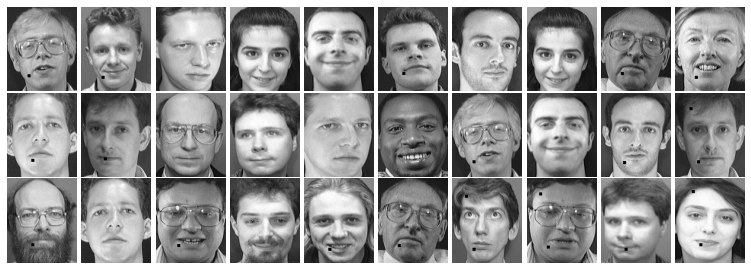

In [9]:
F.show_data_figures(np.array(X_train_list[0])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [10]:
y_train_list[0][0:number_samples_for_show]

array([2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 3, 2, 0,
       2, 0, 2, 2, 3, 3, 2, 3])

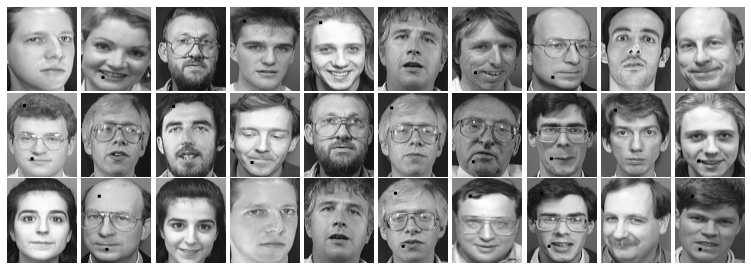

In [11]:
F.show_data_figures(np.array(X_train_list[1])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [12]:
y_train_list[1][0:number_samples_for_show]

array([0, 2, 0, 1, 1, 0, 3, 2, 0, 0, 3, 0, 1, 2, 0, 1, 2, 2, 1, 2, 0, 3,
       0, 0, 0, 3, 1, 3, 0, 3])

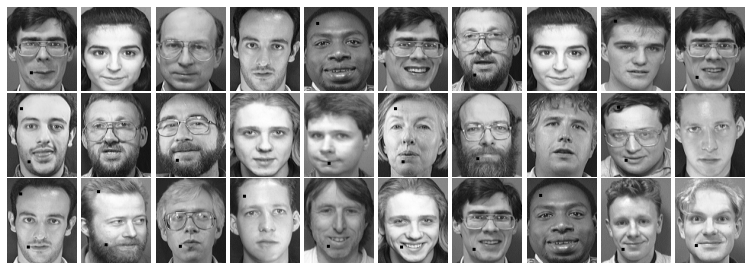

In [13]:
F.show_data_figures(np.array(X_test_list[0])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [14]:
y_test_list[0][0:number_samples_for_show]

array([2, 0, 0, 0, 1, 0, 2, 0, 1, 2, 3, 0, 2, 0, 2, 3, 2, 0, 3, 0, 3, 3,
       2, 1, 2, 2, 2, 1, 2, 2])

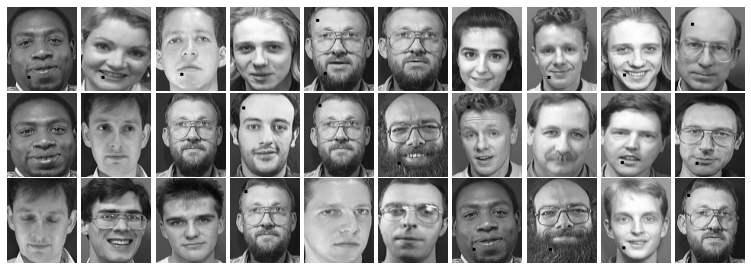

In [15]:
F.show_data_figures(np.array(X_test_list[1])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [16]:
y_train_list[1][0:number_samples_for_show]

array([0, 2, 0, 1, 1, 0, 3, 2, 0, 0, 3, 0, 1, 2, 0, 1, 2, 2, 1, 2, 0, 3,
       0, 0, 0, 3, 1, 3, 0, 3])

# 4 Model

In [ ]:
for time_i in np.arange(sampling_times):
    p_X_train=X_train_list[time_i]
    p_X_test=X_test_list[time_i]
    p_y_train=y_train_list[time_i]
    p_y_test=y_test_list[time_i]
    
    gene_scores_list=[]
    
    for seed_i in seed_range:
        print("seed_i",seed_i)
        forest=RandomForestClassifier(n_estimators=p_n_estimators,n_jobs=-1,random_state=seed_i)
        forest.fit(p_X_train,p_y_train)
        importances=forest.feature_importances_
        gene_scores_list.append(importances)
        
        Acc_train=forest.score(p_X_train,p_y_train)
        Acc_test=forest.score(p_X_test,p_y_test)
        p_y_pred=forest.predict(p_X_test)
        
        F.write_to_csv(np.array([Acc_train]),"./RF_results/predicated_results_sl3_2M_4L.csv")
        F.write_to_csv(np.array([Acc_test]),"./RF_results/predicated_results_sl3_2M_4L.csv")
        F.write_to_csv(p_y_pred.reshape(1,p_y_pred.shape[0]),"./RF_results/predicated_results_sl3_2M_4L.csv")
        F.write_to_csv(p_y_test.reshape(1,p_y_test.shape[0]),"./RF_results/predicated_results_sl3_2M_4L.csv")
        
    del importances,Acc_train,Acc_test,p_y_pred
    gc.collect()
    
    scoring_genes_each_sampling=(np.sum(gene_scores_list, axis=0)).reshape(1,original_edge_length*original_edge_width)
    
    del gene_scores_list
    gc.collect()
    
    F.write_to_csv(scoring_genes_each_sampling,"./RF_results/preprocessed_results_sl3_2M_4L.csv")
    
    #write_to_csv(scoring_genes_each_sampling,"data.csv")
    
    del scoring_genes_each_sampling
    gc.collect()
    
    print("Completed the computation for "+str(time_i+1)+" sampling(s)!\n\n")
    
print("Completed!")

seed_i 44
seed_i 47
seed_i 64
seed_i 67
seed_i 67
seed_i 9
seed_i 83
seed_i 21
seed_i 36
seed_i 87
seed_i 70
seed_i 88
seed_i 88
seed_i 12
seed_i 58
seed_i 65
seed_i 39
seed_i 87
seed_i 46
seed_i 88
seed_i 81
seed_i 37
seed_i 25
seed_i 77
seed_i 72
seed_i 9
seed_i 20
seed_i 80
seed_i 69
seed_i 79
seed_i 47
seed_i 64
seed_i 82
seed_i 99
seed_i 88
seed_i 49
seed_i 29
seed_i 19
seed_i 19
seed_i 14
seed_i 39
seed_i 32
seed_i 65
seed_i 9
seed_i 57
seed_i 32
seed_i 31
seed_i 74
seed_i 23
seed_i 35
seed_i 75
seed_i 55
seed_i 28
seed_i 34
seed_i 0
seed_i 0
seed_i 36
seed_i 53
seed_i 5
seed_i 38
seed_i 17
seed_i 79
seed_i 4
seed_i 42
seed_i 58
seed_i 31
seed_i 1
seed_i 65
seed_i 41
seed_i 57
seed_i 35
seed_i 11
seed_i 46
seed_i 82
seed_i 91
seed_i 0
seed_i 14
seed_i 99
seed_i 53
seed_i 12
seed_i 42
seed_i 84
seed_i 75
seed_i 68
seed_i 6
seed_i 68
seed_i 47
seed_i 3
seed_i 76
seed_i 52
seed_i 78
seed_i 15
seed_i 20
seed_i 99
seed_i 58
seed_i 23
seed_i 79
seed_i 13
seed_i 85
seed_i 48
Completed t